In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models # add models to the list
from torchvision.utils import make_grid
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

### Defining Transforms

In [3]:
train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

In [38]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, root_dir, label_file, class_names, class_to_idx, transform=None):
        self.root_dir = root_dir
        self.label_file = label_file
        self.class_names = class_names
        self.class_to_idx = class_to_idx
        self.transform = transform

        # Read the labels from the Excel file
        self.labels = pd.read_excel(label_file, usecols=[2], names=['gender'])['gender'].tolist()

        # Get the list of image files (without the lambda it was not in order)
        self.image_files = []
        for root, dirs, files in os.walk(root_dir): 
            self.image_files.extend([os.path.join(root, file) for file in sorted(files, key=lambda x: int(''.join(filter(str.isdigit, x))))])

        
        # print(self.labels)
        # print(self.image_files)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load the image and apply the transformation
        image = Image.open(self.image_files[idx])
        if self.transform:
            image = self.transform(image)

        # Convert the label to a tensor
        label = torch.tensor(self.labels[idx])

        print(idx)
        print(self.labels[idx])

        
        return image, label

# Define the root directory of the dataset and the label file
root_dir = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\celeba\img'
label_file = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23\celeba\labels.xlsx'
root_dir_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\celeba_test\img'
label_file_test = r'C:\Users\salda\Documents\Tanulas\4th_year\ELEC0134_AMLS1\dataset_AMLS_22-23_test\celeba_test\labels.xlsx'

# Define the class names and their corresponding indexes
class_names = ['men', 'women']
class_to_idx = {'men': 1, 'women': -1}

train_data = MyDataset(root_dir, label_file, class_names, class_to_idx, transform=train_transform)
test_data = MyDataset(root_dir_test, label_file_test, class_names, class_to_idx, transform=test_transform)

torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=True)

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')



['men', 'women']
Training images available: 5000
Testing images available:  1000


Displaying a batch of images

2256
1
207
-1
1925
1
4987
1
4691
1
2170
-1
3319
1
1020
-1
2799
-1
4548
1
Label: [ 1 -1  1  1  1 -1  1 -1 -1  1]
Class: Man Woman Man Man Man Woman Man Woman Woman Man


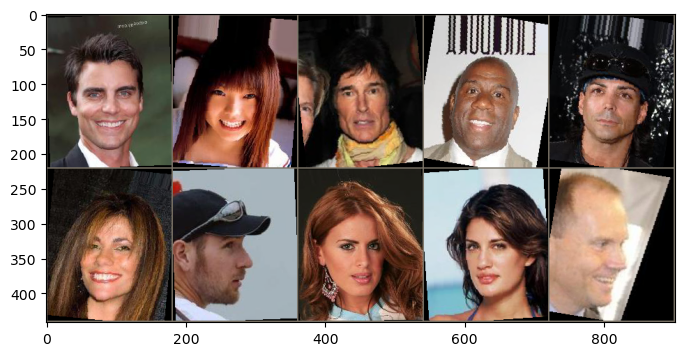

In [51]:
# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class:', *np.array(['Woman' if x == -1 else 'Man' for x in labels.numpy()]))

im = make_grid(images, nrow=5)  # the default nrow is 8

# Inverse normalize the images
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)
im_inv = inv_normalize(im)

# Print the images
plt.figure(figsize=(12,4))
plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)));


# Defining the model

In [52]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # (((224−2)/2)−2)/2=43
        # (((218−2)/2)−2)/2=53
        self.fc1 = nn.Linear(43*53*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 43*53*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [53]:
torch.manual_seed(42)
CNNmodel = ConvolutionalNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(CNNmodel.parameters(), lr=0.001)
CNNmodel

ConvolutionalNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36464, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

In [61]:
import time
start_time = time.time()

epochs = 3

max_trn_batch = 800
max_tst_batch = 300

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):

        # Changing the labels to be in the range [0, num_classes-1].
        y_train = torch.where(y_train == 1, torch.tensor(1), torch.tensor(0))
        
        # Limit the number of batches
        if b == max_trn_batch:
            break
        b+=1
        
        # Apply the model
        y_pred = CNNmodel(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print interim results
        if b%200 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/8000]  loss: {loss.item():10.8f}  \  accuracy: {trn_corr.item()*100/(10*b):7.3f}%')

    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr.detach().numpy())

    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            # Limit the number of batches
            if b == max_tst_batch:
                break

            # Changing the labels to be in the range [0, num_classes-1].
            y_test = torch.where(y_test == 1, torch.tensor(1), torch.tensor(0))

            # Apply the model
            y_val = CNNmodel(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss.detach().numpy())
    test_correct.append(tst_corr.detach().numpy())


print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

2737
-1
1031
1
532
-1
3533
-1
1411
-1
867
-1
3695
1
2425
1
4378
1
2730
-1
3040
-1
3490
1
2333
-1
79
1
1534
-1
2755
-1
3062
1
3239
-1
2867
1
4673
1
1927
-1
1754
-1
2203
1
1511
-1
4571
1
4831
1
613
-1
2345
1
4366
1
480
1
2243
-1
1907
-1
2221
-1
719
1
4448
1
2461
-1
4393
1
3005
1
416
1
4219
-1
4855
1
1938
1
3814
-1
1761
-1
4384
1
1971
-1
169
-1
1129
-1
1246
1
4952
1
2652
-1
4407
1
4162
1
1795
-1
4644
1
699
1
1670
-1
4608
1
946
-1
2893
-1
4750
1
4504
1
3918
-1
1374
-1
4679
1
1451
1
2558
1
1154
-1
3308
1
2940
-1
3007
-1
4554
1
3014
1
2160
-1
4870
1
2280
1
908
-1
3324
1
4782
1
888
1
3872
1
1356
1
3633
1
1714
1
423
-1
293
1
2722
1
3910
-1
4017
1
904
1
2723
1
147
-1
3386
1
1345
-1
2942
-1
4118
-1
772
1
1092
-1
3483
-1
71
1


KeyboardInterrupt: 

Saving the model


In [57]:
torch.save(CNNmodel.state_dict(), 'CustomImageCNNModel.pt')

In [59]:
plt.plot(train_losses.detach(), label='training loss')
plt.plot(test_losses.detach(), label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend();

AttributeError: 'list' object has no attribute 'detach'